In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline  

In [2]:
import matplotlib.pyplot as plt
import torch
from scipy import stats
import numpy as np

/homes/gws/wz86/miniconda3/envs/CSE599G1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import loggers
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from src import data, models

In [7]:
attention_layers = 2
conv_layers = 6
conv_repeat = 1
filter_number = 512
h_layers = 2
hidden_size = 256
kernel_length = 7
kernel_number = 1024
kernel_size = 5
learning_rate = 0.0001
num_rel_pos_features = 66
pooling_size = 2


trainloader, valloader, testloader = data.load_data("../data/encode_roadmap.h5")
single_model = models.Transformer(
    kernel_number=kernel_number,
    kernel_length=kernel_length,
    filter_number=filter_number,
    kernel_size=kernel_size,
    pooling_size=pooling_size,
    conv_layers=conv_layers,
    conv_repeat=conv_repeat,
    attention_layers=attention_layers,
    hidden_size=hidden_size,
    dropout=0.2,
    h_layers=h_layers,
    pooling_type="avg",
    learning_rate=learning_rate,
    num_rel_pos_features=num_rel_pos_features,
)

trainer = pl.Trainer(
    devices=[2],
    accelerator="gpu",
    benchmark=False,
    profiler="simple",
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
checkpoint_path = '../output/tf/2_66_6_1_1024_7_512_5_2_0.0001_2_256/epoch=9-step=73440.ckpt'

predictions = trainer.predict(single_model, dataloaders=[valloader], ckpt_path=checkpoint_path)
predictions = torch.cat(predictions, dim=0).cpu().numpy()

all_pred = predictions[:, :164]
all_truth = predictions[:, 164:]

Missing logger folder: /homes/gws/wz86/CSE599G1-Final-Project/scripts/lightning_logs
Restoring states from the checkpoint path at ../output/tf/2_66_6_1_1024_7_512_5_2_0.0001_2_256/epoch=9-step=73440.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from checkpoint at ../output/tf/2_66_6_1_1024_7_512_5_2_0.0001_2_256/epoch=9-step=73440.ckpt
/homes/gws/wz86/miniconda3/envs/CSE599G1/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 274/274 [00:58<00:00,  4.72it/s]

PREDICT Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                       	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

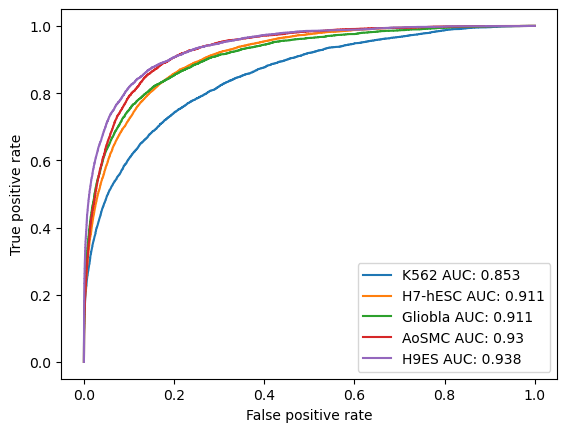

In [24]:
cell_indices = [('K562',120), ('H7-hESC',55), ('Gliobla',6), ('AoSMC',1), ('H9ES',13)]

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
all_auc_score = []
for name, i in cell_indices:
    pred = all_pred[:, i]
    truth = all_truth[:, i]
    fpr, tpr, thresholds = metrics.roc_curve(truth, pred)
    plt.plot(fpr, tpr)
    score = metrics.roc_auc_score(truth, pred)
    all_auc_score.append(name + " AUC: " + str(round(score, 3)))

plt.legend(all_auc_score)
plt.show()